In [1]:
import numpy as np
import pandas as pd
import scipy.io
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Reimport functions
import imp
imp.reload(ief)

In [2]:
# Define frequency bands
freq_bands=[(0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
n_band=len(freq_bands)
print('# of freq bands %d' % n_band)

# of freq bands 6


In [3]:
# Load an example data set
#in_fname='/home/dgroppe/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat'
in_fname='/Users/davidgroppe/ONGOING/TWH_EEG_ORIG/NA/NA_d1_sz2.mat'
mat_dat=sio.loadmat(in_fname)
Sf=mat_dat['Sf']
#mat_dat.keys()

if Sf==500:
    # Downsample to 250 Hz
    print('Downsampling data to 250 Hz')
    vltg_dat=signal.decimate(mat_dat['matrix_bi'],2,axis=0,zero_phase=True)
    Sf=250
elif Sf==250:
    vltg_dat=mat_dat['matrix_bi']
else:
    raise ValueError('Sf needs to be 500 or 250')

# Get SOZ chan
# soz_id=0 # TODO ?? get actual chan
# n_tpt, n_chan=mat_dat['matrix_bi'].shape
n_tpt, n_chan=vltg_dat.shape
data_time_sec=np.arange(0,n_tpt)/Sf

# Detrend data. Some patients have a crazy trend in the first channel
dat=signal.detrend(vltg_dat,0)
# plt.figure(1)
# plt.clf()
# plt.plot(mat_dat['matrix_bi'][:,0],'b-')
# plt.plot(dat[:,0],'r--')

bp_data=np.zeros((n_band,n_chan,n_tpt))
filt_order=4
# Bandpass filter the data
for band_ct, band in enumerate(freq_bands):
    print('Working on {} Hz'.format(band))
    bp_data[band_ct,:,:]=ief.causal_butter(dat.T,Sf,band,filt_order)
    
# plt.figure(2)
# plt.clf()
# plt.plot(dat[:,0],'r-')
# plt.plot(bp_data[0,0,:],'g--')
# plt.plot(bp_data[3,0,:],'m--')

Downsampling data to 250 Hz
Working on (0, 4) Hz
Working on (4, 8) Hz
Working on (8, 13) Hz
Working on (13, 30) Hz
Working on (30, 50) Hz
Working on (70, 100) Hz


In [4]:
# Apply NON-causal hilbert transform
hilby_data=signal.hilbert(bp_data)
print('done!')

done!


In [5]:
# Import Channel Info
in_fname='/Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv'
chan_df=pd.read_csv(in_fname,names=['Channel'])
for chan_ct, chan in enumerate(chan_df['Channel']):
    print('%d: %s' % (chan_ct,chan))
#pd.read_csv?

0: LHD1-LHD2
1: LHD2-LHD3
2: LHD3-LHD4
3: LAT1-LAT2
4: LAT2-LAT3
5: LAT3-LAT4
6: LMT1-LMT2
7: LMT2-LMT3
8: LMT3-LMT4
9: LPT1-LPT2
10: LPT2-LPT3
11: LPT3-LPT4
12: RHD1-RHD2
13: RHD2-RHD3
14: RHD3-RHD4
15: RAT1-RAT2
16: RAT2-RAT3
17: RAT3-RAT4
18: RMT1-RMT2
19: RMT2-RMT3
20: RMT3-RMT4
21: RSPT1-RSPT2
22: RSPT2-RSPT3
23: RSPT3-RSPT4
24: RSPT4-RSPT5
25: RSPT5-RSPT6
26: RIPT1-RIPT2
27: RIPT2-RIPT3
28: RIPT3-RIPT4
29: RIPT4-RIPT5
30: RIPT5-RIPT6


In [6]:
# Extract power magnitude from hilbert transform
soz_id=12
bp_mag=np.abs(hilby_data[:,soz_id,:])

In [12]:
bp_data.shape

(6, 31, 46750)

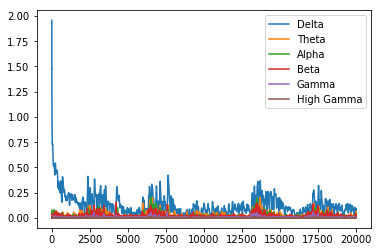

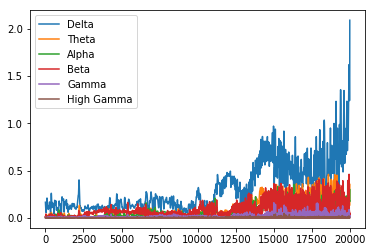

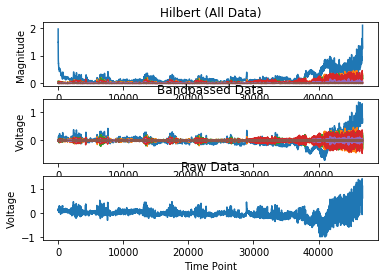

In [19]:
plt.figure(1)
plt.clf()
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,0:20000].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(2)
plt.clf()
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,-20000:].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(3)
plt.clf()
plt.subplot(3,1,1)
for band_ct in range(n_band):
    plt.plot(bp_mag[band_ct,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Hilbert (All Data)')
plt.ylabel('Magnitude')

plt.subplot(3,1,2)
for band_ct in range(n_band):
    plt.plot(bp_data[band_ct,soz_id,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Bandpassed Data')
plt.ylabel('Voltage')

plt.subplot(3,1,3)
plt.plot(dat[:,soz_id])
plt.title('Raw Data')
plt.xlabel('Time Point')
plt.ylabel('Voltage')

plt.savefig('hilbert_mag_all_data.png')


In [ ]:
# Square, Log transform and z-score features for comparison with DFT features
bp_mag_z=np.log(bp_mag.copy()**2)
# print(bp_mag[0,0])
# print(bp_mag_z[0,0])
dg.trimmed_normalize(bp_mag_z,0.4);

In [ ]:
# Load DFT based features and compare with Hilbert based Features
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/NA/NA_d1_sz2_bppwr.npz'
dft=np.load(in_fname)
dft.keys()

n_dft_tpt=len(dft['time_wind_sec'])
resamp_bp_mag_z=np.zeros((n_band,n_dft_tpt))
for a in range(n_dft_tpt):
    match_id=dg.find_nearest(hilby_time_sec,dft['time_wind_sec'][a])
    resamp_bp_mag_z[:,a]=np.mean(bp_mag_z[:,match_id-125:match_id+125],axis=1)

In [ ]:
print(dft['time_wind_sec'].shape)
print(hilby_time_sec.shape)
bro=np.mean(bp_mag_z[:,match_id-125:match_id+125],axis=1)
bro.shape

In [ ]:
plt.figure(3)
plt.clf()
for band_ct in range(n_band):
    plt.plot(resamp_bp_mag_z[band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(4)
plt.clf()
for band_ct in range(n_band):
    plt.plot(dft['ftrs'][band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()

In [ ]:
dft['ftrs'].shape

In [ ]:
bp_data.shape
print(n_half_wind*2)
print(hilby.shape)
print(type(hilby))
print(type(hilby_data))
print(hilby_data[0,0,2000:2020])

In [ ]:
hilby=signal.hilbert(bp_data[:,:,(tpt-n_half_wind):(tpt+n_half_wind)])
print(hilby.shape)